In [1]:
from typing import List, NamedTuple, Tuple, Union, Dict

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from msi_zarr_analysis.ml.dataset.cytomine_ms_overlay import get_overlay_annotations
from msi_zarr_analysis.ml.dataset.translate_annotation import (
    TemplateTransform,
    match_template_ms_overlay,
    rasterize_annotation_mapping,
    translate_parsed_annotation_mapping,
)
from msi_zarr_analysis.utils.check import open_group_ro
from msi_zarr_analysis.utils.cytomine_utils import get_page_bin_indices
from msi_zarr_analysis.utils.autocrop import autocrop

import tifffile
import pathlib
import shutil

from scripts.connect_from_json import connect


class DSConfig(NamedTuple):
    image_id_overlay: int  # Cytomine ID for the overlay image
    local_overlay_path: str  # local path of the (downloaded) overlay
    lipid_tm: str  # name of the lipid to base the template matching on

    project_id: int  # project id
    annotated_image_id: int  # image with the annotations

    classes: Dict[str, List[int]]

    save_image: Union[bool, str] = False

    transform_rot90: int = 0
    transform_flip_ud: bool = False
    transform_flip_lr: bool = False

    annotation_users_id: Tuple[int] = ()  # select these users only

    zarr_template_path: str = None  # use another group for the template matching

In [2]:
config = DSConfig(
    **{
        "image_id_overlay": 545025763,
        "local_overlay_path": "../datasets/Adjusted_Cytomine_MSI_3103_Region013-Viridis-stacked.ome.tif",
        "lipid_tm": "LysoPPC",
        "project_id": 542576374,
        "annotated_image_id": 545025783,
        "transform_rot90": 1,
        "transform_flip_ud": True,
        "transform_flip_lr": False,
        "annotation_users_id": (),
        "zarr_template_path": "../datasets/comulis13_binned.zarr",
    },
    classes={  # both merged
        #"+": [544926081, 544924846],
        #"-": [544926097, 544926052],
        "LS": [544926097, 544926081],
        "SC": [544926052, 544924846],
    },
)

template_transform = TemplateTransform(
    rotate_90=config.transform_rot90,
    flip_lr=config.transform_flip_lr,
    flip_ud=config.transform_flip_ud,
)

lipid = "LysoPPC"
lipid_df_path = "../mz value + lipid name.csv"

group_binned = open_group_ro(config.zarr_template_path)

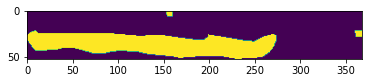

In [3]:
z_len = group_binned["/labels/lengths/0"]
presence_mask = z_len[0, 0] > 0

selection_tpl = autocrop(presence_mask)
plt.imshow(presence_mask[selection_tpl])

In [4]:
lipids_planes = group_binned["/0"][(slice(None), 0) + selection_tpl]
lipids_planes.shape # C H W

(37, 53, 368)

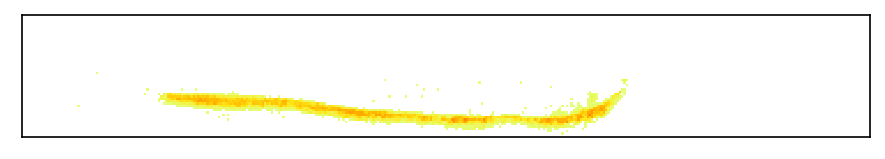

In [5]:
# colorization using below colormap
fig, ax = plt.subplots(dpi=150)
img = lipids_planes[14]
ax.imshow(np.where(img == 0, np.nan, img), interpolation="nearest", cmap="Wistia")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

fig.tight_layout()

In [14]:
# FIXME: dest should be a dir
# then all planes should be saved with _{idx}.tiff suffix to form the stack
# then the stack folders can be downloaded
def save_as_tiff(dest: str, img: np.ndarray, cross_lipid_norm: bool):
    
    dest = pathlib.Path(dest)
    if dest.exists():
        shutil.rmtree(dest)
    dest.mkdir()

    img_max_val = img.max()
    background = img == 0
    
    planes = []
    for p in img:
        if cross_lipid_norm:
            p = p / img_max_val
        else:
            max_val = p.max()
            if max_val != 0:
                p = p / max_val
        color_map = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
        planes.append(color_map.to_rgba(p, bytes=True, norm=False))
        del color_map
    
    assert img[~np.isnan(img)].max() == 0 or max([p.max() for p in planes]) > 0, img[~np.isnan(img)].max()
    
    stem = dest.stem

    for idx, p in enumerate(planes):
        #p[background[idx], 3] = 0
        p = p[..., :3]
        
        plane_path = dest / (stem + f"_{idx}.tiff")
        with tifffile.TiffWriter(plane_path) as tiff_writer:
            tiff_writer.write(p, photometric="RGB")

    return planes

In [15]:
save_as_tiff("../region13-viridis-lipids-msi-inter-normalization.stack", lipids_planes, cross_lipid_norm=True)
planes = save_as_tiff("../region13-viridis-lipids-msi-intra-normalization.stack", lipids_planes, cross_lipid_norm=False)

In [ ]:
connect("../config_cytomine.json")

# template matching...
page_idx, bin_idx, *_ = get_page_bin_indices(
    image_id=config.image_id_overlay, lipid=lipid, csv_lipid_mz_path=lipid_df_path
)

annotation_dict = get_overlay_annotations(
    project_id=config.project_id,
    image_id=config.image_id_overlay,
    classes=config.classes,
    select_users=config.annotation_users_id,
)

In [ ]:
print(bin_idx)

In [ ]:
matching_result, crop_idx = match_template_ms_overlay(
    group_binned,
    bin_idx,
    config.local_overlay_path,
    page_idx,
    template_transform,
)

In [ ]:
annotation_dict = translate_parsed_annotation_mapping(
    annotation_dict,
    template_transform,
    matching_result,
    (
        slice(crop_idx[0].start - selection_tpl[0].start, None),
        slice(crop_idx[1].start - selection_tpl[1].start, None),
    )
)  # VICTORY : these are the good annotations

In [ ]:
# get base image
# img = group_binned["/0"][bin_idx, 0]
img = planes[28]

In [ ]:
# rasterize annotations
full_shape = img.shape[:2]
raster_dict = rasterize_annotation_mapping(
    annotation_dict,
    full_shape,
)

In [ ]:
fig, ax = plt.subplots(dpi=150)

#img = template_transform.transform_template(img)

# plot img
#img[img < 200] = np.nan
#ax.imshow(img, interpolation="nearest", cmap="Wistia")
ax.imshow(img, interpolation="nearest")

# plot annotations
for color, (cls_label, annotation_lst) in zip(['tab:cyan', 'tab:purple'], raster_dict.items()):
    print(f"{cls_label}: {color}")
    
    min_val = min(a.raster.min() for a in annotation_lst) 
    max_val = max(a.raster.max() for a in annotation_lst)
    
    cmap = LinearSegmentedColormap.from_list(color, [
        (min_val, "#0000"),
        (max_val, color),
    ])

    for annotation in annotation_lst:
        #mask = template_transform.transform_template(annotation.raster)
        mask = annotation.raster
        ax.imshow(mask, alpha=0.8, cmap=cmap)

#ax.set_title(f"Annotated MSI: Region 13 {lipid}, LS/SC")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

fig.tight_layout()

#fig.savefig("annotated_crop.png")

In [ ]:
# get the image ID of Cytomine